# ODSC West 2022 Tutorial: 
### Objective: Understand how to transform, clean, and visualize the RR series as instant heart rate
- Kirstin Aschbacher
- Sept 2022

In [11]:
from typing import List
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.width", 500)
np.printoptions("precision", 2)

### Load an example time series of data 
* This data was acquired using a commercially available ear clip device.
* It employs photoplethysmography (PPG) to measure changes in blood volume flowing through small blood vessels in the ear lobe.
* The ear has desirable properties for HRV biofeedback, as it is less susceptible to movement artifacts than the fingertip.
* The device uses its own peak detection algorithm to estimate the timing of heart beats. The device transmits a time series representing the interval (in milliseconds) between each heart beat, which we will call the RR interval. (Although, technically an RR interval is defined based off an electrocardiogram, which takes measurements in different ways. The full complexity of these measurements is beyond the scope of this tutorial.) 
* This data did not come from a participant enrolled in Meru Health's program.  Rather, it came from a volunteer who consented to have their data made public for the purposes of this tutorial.
* Reference: https://www.sciencedirect.com/topics/nursing-and-health-professions/rr-interval#:~:text=The%20RR%20interval%2C%20the%20time,as%20well%20as%20autonomic%20influences.


In [12]:
hrv_fpath = "data/odsc_testdata_edited.csv"
df = pd.read_csv(hrv_fpath, encoding="utf-8", index_col="rawrrID")
df.head(3)

rawRR
rawrrID       
0          843
1          882
2          914

### Preprocess Data for one user

In [13]:
def preprocess(user_df: pd.DataFrame, col: str="rawRR") -> pd.DataFrame:
    """Build a time vector from the RR or NN intervals.
    Build an instant HR column from the RR or NN intervals.
    """

    # Compute time in seconds, so that the first beat starts at 0 seconds
    firstHR = user_df[col].iloc[0] / 1000
    user_df["time"] = user_df[col].cumsum() / 1000 - firstHR

    # Compute instant HR from raw RR
    user_df["heartRate"] = np.divide(60000, user_df[col])
    return user_df

In [14]:
df = preprocess(df)
df.head(3)

rawRR   time  heartRate
rawrrID                         
0          843  0.000  71.174377
1          882  0.882  68.027211
2          914  1.796  65.645514

### Build a Plotting Function
<h5> In order to help illustrate how different types of breathing impact one's heart rate, this test user modulated their breath as follows:</h5>
<ul>
<li>1) HRVB following pacer</li>
<li>2) Harder HRVB = HRVB following breath only while reading - i.e., a divided attentional challenge</li>
<li>3) Breath of Fire (yogic fast breathing technique)</li>
<li>4) Return to HRVB at the very end</li>
</ul>

In [5]:
def plot_heartrate_colored_by_condition(user_df: pd.DataFrame) -> None:
    """Plot the time series of instant heart rate data"""
    time = user_df["time"]
    hr = user_df["heartRate"]

    # Segment the data by experimental condition
    # -- 1) HRVB following pacer
    # -- 2) Harder HRVB = HRVB following breath only while reading - i.e., a divided attentional challenge
    # -- 3) Breath of Fire (yogic fast breathing technique)
    # -- 4) Return to HRVB at the very end
    end_hrvb = time[time <= 2.25 * 60].shape[0]
    end_soundonly = time[time <= 3.25 * 60].shape[0]
    end_breath_of_fire = time[time <= 4.4 * 60].shape[0]
    
    # Plot the data - give each condition a separate color
    plt.figure(figsize=(18, 3))
    plt.plot(time[:end_hrvb], hr[:end_hrvb], color="navy")
    plt.plot(time[end_hrvb-1:end_soundonly], hr[end_hrvb-1:end_soundonly], color="teal")
    plt.plot(time[end_soundonly-1:end_breath_of_fire], hr[end_soundonly-1:end_breath_of_fire], color="crimson")
    plt.plot(time[end_breath_of_fire-1:], hr[end_breath_of_fire-1:], color="navy")
    
    plt.xlabel("Seconds", fontsize=14)
    plt.ylabel("Instant Heart Rate", fontsize=14)
    plt.title("Instant Heart Rate during HRVB and comparison conditions", fontsize=16)
    plt.show()

#### Experimental Observations
* We can see that how fast we breathe and whether we are distracted during the task can impact the signal quality.
* 1) (Heart Rate Variability Biofeedback=HRVB, Navy) Regular, slow breathing at 6 breaths per minute causes these high-amplitude changes in heart rate variability as seen below.
* 2) (HRVB + Multitasking, Teal) When adding a cognitive challenge - reading while continuing to breathe, but now following only the auditory feedback - we see this user is able to manage the task, but has a few more "wiggles" in the signal, revealing some of the difficulty of multitasking.  Also the mean heart rate shifts up as the task demands increase, reflecting mild mental stress of increased cognitive load.
* 3) (Fast Breathing, Red) Here the user performs "breath of fire" - a type of fast breathing with muscular pumping of the diaphragm.  The HRVB sine wave disappears within about 10 seconds and the waveform is now characterized by high frequency, low-amplitude changes in HRV.  Heart rate increases, potentially reflecting the effort or changes in carbon dioxide induced by this type of breathing.
* 4) (Return to HRVB, navy)  The characteristic sinusoidal pattern quickly reemerges as the user shifts back to six breaths per minute.

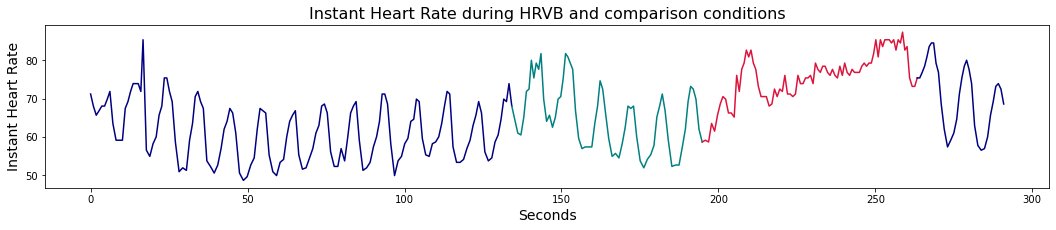

In [6]:
plot_heartrate_colored_by_condition(df)

### Cleaning Artifacts  
* In the plot above, you can see there's an artifact in the signal
* It might be an ectopic beat or some other kind of artifact.
* We want to remove these outlier points and interpolate them.
* Below I've built a rolling window function to clean ectopic beats

In [15]:
def ectopic_removal(
        rr: np.ndarray, bounds: List[float]
    ) -> np.ndarray:
        """Remove ectopic beats from an rr interval series,
        using Aschbacher's modification of Kamath method.
        """
        assert 0 < bounds[0] < 1
        assert 1 < bounds[1]
        assert np.isnan(rr).sum() == 0

        # Initialize empty array for new rrs. First & last.
        nn = np.asarray([np.nan for i in range(rr.shape[0])])
        nn[0] = rr[0]
        nn[-2:] = rr[-2:]

        # We will use a window of length=3
        for i in range(0, len(rr) - 2):

            # Find the mean of the two outer points of the window
            w_mean = np.nanmean([rr[i], rr[i+2]])

            # Retain points that lie within the bounds around the mean, otherwise leave as np.nan
            if w_mean * bounds[0] < rr[i+1] < w_mean * bounds[1]:
                nn[i+1] = rr[i+1]
            else:
                print(f"nan'ed out index={i+1}")
        
        return nn

### Now you will see the artifact is removed!
* As a final observation, this user had recovered from covid several weeks prior, but still had minor residual respiratory symptoms.
* The minor restrictions on the inhale, experienced as "chest tightness" by the user, are visible as a slight slanting of the sinewave, so that it looks a bit more like a triangle pointed up and to the right.  

nan'ed out index=19
Number of beats removed = 1


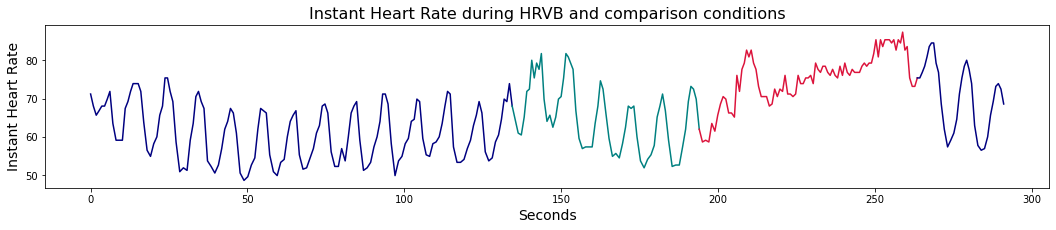

In [16]:
df["nn"] = ectopic_removal(df["rawRR"].values, bounds=[0.755, 1.25])
print(f"Number of beats removed = {df['nn'].isna().sum()}")

df["nn"] = df["nn"].interpolate(method="spline", order=3)
df = preprocess(df, col="nn")
plot_heartrate_colored_by_condition(df)

# Congratulations!
##### You've completed the second tutorial.  
##### Now you understand how to preprocess and plot the data.  You have learned how changing the speed and the way you breathe, as well as your cognitive or attentional processing, can affect the morphology of the waveform. 
##### Next, we will learn how to use rolling windows and curve fitting models to fit this data.